# Autoencoder Ensemble Classification
**Author**: Adam Good

**description**: This is a proof of concept. The main idea is to create an ensemble of auto encoders where each base encoder is trained to reconstruct one class in particular. For classification, an image is fed to each autoencoder for reconstruction. The reconstructive loss is calculated. In theory, each autoencoder that is *not* trained on the correct class will have high reconstructive loss, whereas the autoencoder trained on the correct class will have a significantly lower reconstructive loss. By choosing the autocoder with the minimum reconstructive loss, the model should choose the proper class.

While this option probably takes significantly more training than normal classifiers, it was an interesting idea and may result in high percision classification.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.notebook import  tqdm

import matplotlib.pyplot as plt

SEED=8675309
np.random.seed(SEED)

%matplotlib inline

## Model Design

### Fully Connected Auto Encoder

**Description**: This is a simple, fully connected autoencoder built for reconstructing an image with values in the range $[0,1]$. This would ideally be good for data similar to MNIST.

In [2]:
class FCAutoencoder(nn.Module):
    
    def __init__(self, input_shape, latent_size):
        super(FCAutoencoder, self).__init__()
        
        self.channels, self.in_width, self.in_height = input_shape
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Linear(self.channels * self.in_width * self.in_height, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, self.latent_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.channels * self.in_width * self.in_height),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, self.channels, self.in_width, self.in_height)
        return x
        


### Convolutional Auto Encoder

**Description**: This is a convolutional autoencoder. The input is expected to be images of values in the range $[0,1]$.

In [3]:
# Based on https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/blob/master/main.py
class ConvAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_size):
        super(ConvAutoencoder, self).__init__()
        
        self.channels, self.in_width, self.in_height = input_shape
        self.latent_size = latent_size
        
        self.conv_enc = nn.Sequential(
            nn.Conv2d(in_channels=self.channels, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc_enc = nn.Sequential(
            nn.Linear(64*self.in_width*self.in_height, 1024),
            nn.ReLU(),
            nn.Linear(1024,  self.latent_size)
        )
        
        self.fc_dec = nn.Sequential(
            nn.Linear(self.latent_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*self.in_width*self.in_height),
            nn.ReLU()
        )
        
        self.conv_dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
#            nn.MaxUnpool2d(kernel_size=2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
#            nn.MaxUnpool2d(kernel_size=2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=self.channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        x = self.conv_enc(x)
        shape = x.shape
        
        x = x.view(x.shape[0], -1)        
        
        x = self.fc_enc(x)
        x = self.fc_dec(x)
        x = x.reshape(shape)
        x = self.conv_dec(x)
        
        return x

### Autoencoder Ensemble Classifier

**Model Description**:

Given a dataset of images and labels $ \mathbb{D} = (\mathbb{X}, \mathbb{Y})$ with a set of $n$ classes $C=\{c_1, c_2, ..., c_n\}$, construct an autoencoder for each class $E = \{e_{c_1}, e_{c_2}, ..., e_{c_n} \}$. By splitting the data by class, train each autoencoder on one class (i.e. train $e_{c_1}$ on class $c_1$, etc.), each autoencoder should learn to reconstruct one specific class well, and not the other classes. In other words, the reconstructive loss of each autoencoder will be low on one class, and significantly higher on all other classes.

Regardless of the loss function used to train the individual autoencoders, this model requires a reconstructive loss function $L(\hat{X}, X)$ that will compute a difference between the input $X$ and the reconstruction $\hat{X}$. Depending on your data, Mean Squared Error or Binary Cross Entropy could be good options.

To classify the data, find the class of the autoencoder that generates the minimum reconstructive loss.
$$
\hat{Y} = \text{argmin}_{i \in C} L(e_i(X), X)
$$

In [4]:
class AutoencoderEnsembleClassifier(nn.Module):
    
    class CostLayer(nn.Module):
        def __init__(self, cost_fn):
            super(AutoencoderEnsembleClassifier.CostLayer, self).__init__()
            self.cost = cost_fn
            
        def forward(self, r, x):
            return self.cost(r,x)
    
    
    def __init__(self, autoencoder_ensemble, recon_cost_fn, max_loss=None):
        super(AutoencoderEnsembleClassifier, self).__init__()
        self.ensemble = autoencoder_ensemble
        self.recon_cost = recon_cost_fn
        
        self.cost_layer = AutoencoderEnsembleClassifier.CostLayer(recon_cost_fn)
        
    def normalize_cost(self, c):
        pass
    
    def forward(self, x):
        fn = lambda r,x: torch.sum((r - x)**2, dim=1)
        
        reconstructions = [M(x) for M in self.ensemble]

        x_flat = x.view(x.shape[0], -1)
        costs = [fn(r.view(x.shape[0], -1) , x_flat) for r in reconstructions]
        costs = [torch.unsqueeze(c, dim=0) for c in costs]
        costs = torch.cat(costs, dim=0)#.reshape(x.shape[0], len(self.ensemble))
        costs = costs.transpose(1,0)
        
        i = torch.argmin(costs, dim=1)
        
        return i


## Experiment

In [5]:
# Here we just define the parameters of the training
train_frac = 0.80
test_frac = 1-train_frac

data='mnist'
data_shape = (1,28,28) if data == 'mnist' else (3,32,32)
latent_size = 32 if data == 'mnist' else 128

batch_size = 256
num_epochs = 1 if data == 'mnist' else 10
learning_rate = 1e-3

In [6]:
# Here we grab the dataset to train on. In this particular example we're using MNIST
#
#
mnist_mean = 0.1307
mnist_stdev = 0.3081

mnist_transform = transforms.Compose([
                                transforms.ToTensor(),
#                                transforms.Normalize((mnist_mean,), (mnist_stdev,))
])

if data == 'cifar10':
    train_set = datasets.CIFAR10('./data', train=True, transform=mnist_transform, download=True)
    test_set = datasets.CIFAR10('./data', train=False, transform=mnist_transform, download=True)    
elif data == 'mnist':
    train_set = datasets.MNIST('./data', train=True, transform=mnist_transform, download=True)
    test_set = datasets.MNIST('./data', train=False, transform=mnist_transform, download=True)

classes = np.unique(train_set.targets)
classes = np.sort(classes)

train_loaders = {}
test_loaders = {}
for i,c in enumerate(classes):
    train_weights = train_set.targets == c
    train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_set)) #ClassSampler(train_set, train_set.targets == c)
    train_loaders[c] = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    
    test_weights = test_set.targets == c
    test_sampler = WeightedRandomSampler(weights=test_weights, num_samples=len(test_set))
    test_loaders[c] = torch.utils.data.DataLoader(test_set, batch_size=batch_size, sampler=test_sampler, num_workers=4)

    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=4)

In [7]:
def train(model, dataloader, criterion, optimizer, train=True, verbose=False, epoch_num=None):
    if verbose:
        loop = tqdm(dataloader)
        num_inputs = 0
        total_inputs = len(dataloader.dataset)
    else:
        loop = dataloader
        
    for data in loop:
        img, label = data
        reconstruction = model(img)
        loss = criterion(reconstruction, img)

        optimizer.zero_grad() # TODO: Should this be at the beginning?
        loss.backward()
        optimizer.step()

        if verbose:
            num_inputs += img.shape[0]
#            loop.write(f'Epoch {epoch_num}: Progress: {num_inputs}/{total_inputs} ~ {num_inputs/total_inputs*100:0.2f}%  Loss={loss.item():0.4f}')
            loop.set_description(f'Epoch {epoch_num}: Loss={loss.item():0.4f}')
#            loop.set_postfix(f'Progress: {num_inputs}/{total_inputs} ~ {num_inputs/total_inputs*100:0.2f}%  Loss={loss.item():0.4f}')

In [8]:
def test(model, dataloader):
    accuracy = 0.0
    total = 0
    
    for data in dataloader:
        img, label = data
        output = model(img)
        acc = (output == label).sum()
        accuracy += acc
        total += len(label)
        
    accuracy /= total
    return accuracy
        

In [9]:
# Train the ensemble of classifiers

#classes = [0]
criterion = nn.MSELoss()
models = {}
for c in classes:
    models[c] = FCAutoencoder(data_shape, latent_size)
    optimizer = optim.Adam(models[c].parameters(), lr=learning_rate)
    print(f"Training Base Model on {c}")
    for epoch in range(num_epochs):
        train(models[c], train_loaders[c], criterion, optimizer, verbose=True, epoch_num=epoch+1)
    print(f'Finished')

Training Base Model on 0



Finished
Training Base Model on 1



Finished
Training Base Model on 2



Finished
Training Base Model on 3



Finished
Training Base Model on 4



Finished
Training Base Model on 5



Finished
Training Base Model on 6



Finished
Training Base Model on 7



Finished
Training Base Model on 8



Finished
Training Base Model on 9



Finished


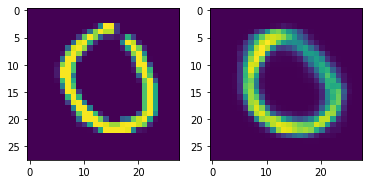

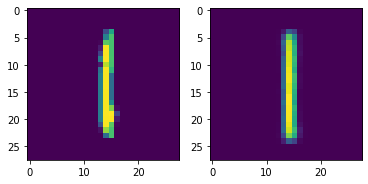

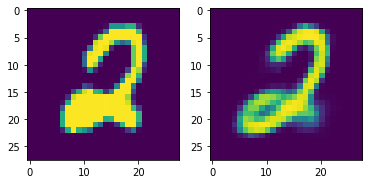

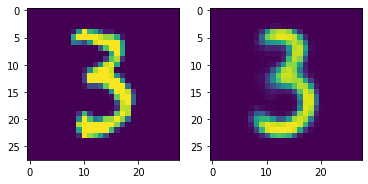

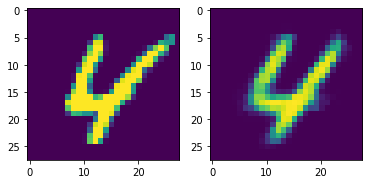

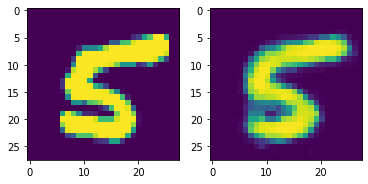

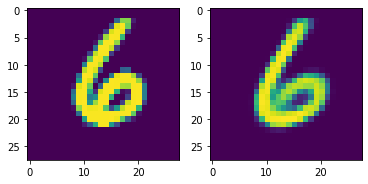

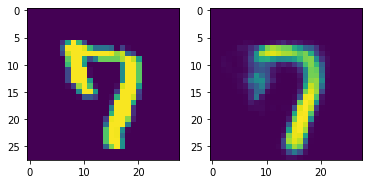

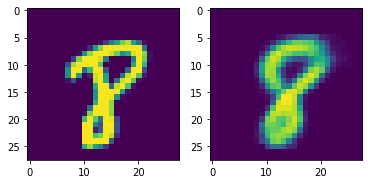

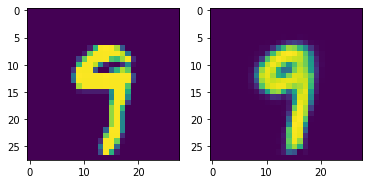

In [10]:

for c in classes:
    X,_ = next(iter(test_loaders[c]))
    y = models[c](X)
    
    if data == 'mnist':
        img_x = X[0].squeeze().detach().numpy()
        img_y = y[0].squeeze().detach().numpy()
    elif data =='cifar10':
        img_x = X[0].detach().numpy().transpose(1,2,0)
        img_y = y[0].detach().numpy().transpose(1,2,0)
        
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_x)
    ax[1].imshow(img_y)
    plt.show()


In [11]:
classifier = AutoencoderEnsembleClassifier( list(models.values()), lambda r,x: nn.MSELoss(r,x).item(), 0)

In [12]:
for c in classes:
    acc = test(classifier, test_loaders[c])
    print(f'{c} : {acc:0.2f}%')


total_acc = test(classifier, test_loader)
print(f'Total: {total_acc:0.2f}')

0 : 0.98%
1 : 0.98%
2 : 0.98%
3 : 0.96%
4 : 0.99%
5 : 0.97%
6 : 0.98%
7 : 0.96%
8 : 0.94%
9 : 0.94%
Total: 0.97
